### Simple GAN 

April 30, 2022 

_Version 2: Train on positive cases only and extract the generated images_

In [1]:
#!pip install nibabel
import nibabel as nib
import numpy as np
import glob
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

np.random.seed(42) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(42)

In [2]:
df = pd.read_csv('/project/ds6050-soa2wg/team_lambda_II/ASD_DSM_CasesvsControls.csv', sep = ',')

In [3]:
df

FILE_ID  DX_GROUP  DSM_IV_TR  SEX DX_Control   DX_DSM    SEX_  \
0      Pitt_0050005         1          1    2     Autism   Autism  Female   
1      Pitt_0050006         1          1    1     Autism   Autism    Male   
2      Pitt_0050007         1          1    1     Autism   Autism    Male   
3      Pitt_0050011         1          1    1     Autism   Autism    Male   
4      Pitt_0050014         1          1    1     Autism   Autism    Male   
..              ...       ...        ...  ...        ...      ...     ...   
386  UCLA_1_0051280         2          0    1    Control  Control    Male   
387  UCLA_1_0051281         2          0    1    Control  Control    Male   
388  UCLA_1_0051282         2          0    2    Control  Control  Female   
389  UCLA_2_0051303         2          0    2    Control  Control  Female   
390  UCLA_2_0051305         2          0    2    Control  Control  Female   

                                                  PATH  
0    /project/ds6050-soa2wg/team_lambda_II/Outputs/...  
1    /project/ds6050-soa2wg/team_lambda_II/Outputs/...  
2    /project/ds6050-soa2wg/team_lambda_II/Outputs/...  
3    /project/ds6050-soa2wg/team_lambda_II/Outputs/...  
4    /project/ds6050-soa2wg/team_lambda_II/Outputs/...  
..                                                 ...  
386  /project/ds6050-soa2wg/team_lambda_II/Outputs/...  
387  /project/ds6050-soa2wg/team_lambda_II/Outputs/...  
388  /project/ds6050-soa2wg/team_lambda_II/Outputs/...  
389  /project/ds6050-soa2wg/team_lambda_II/Outputs/...  
390  /project/ds6050-soa2wg/team_lambda_II/Outputs/...  

[391 rows x 8 columns]

In [4]:
# obtain paths for all images
images_paths_f_case = list(df.query("SEX_ == 'Female' & DX_Control == 'Autism'")['PATH'])
images_paths_f_control = list(df.query("SEX_ == 'Female' & DX_Control == 'Control'")['PATH'])
images_paths_m_case = list(df.query("SEX_ == 'Male' & DX_Control == 'Autism'")['PATH'])
images_paths_m_control = list(df.query("SEX_ == 'Male' & DX_Control == 'Control'")['PATH'])

total_cases = len(images_paths_f_case) + len(images_paths_m_case)
total_controls = len(images_paths_f_control ) + len(images_paths_m_control)
# print out number of participants per category
print('There are {} female cases'.format(str(len(images_paths_f_case))))
print('---------------------------------------')
print('There are {} female controls'.format(str(len(images_paths_f_control))))
print('---------------------------------------')
print('There are {} male cases'.format(str(len(images_paths_m_case))))
print('---------------------------------------')
print('There are {} male controls'.format(str(len(images_paths_m_control))))
print('---------------------------------------')
print(f'There are {total_cases} total cases and {total_controls} total controls! {total_controls + total_cases} participants in total')
# make one giant list
#images_paths = images_paths_f_case  + images_paths_f_control + images_paths_m_case + images_paths_m_control

# positive cases only
#images_paths = images_paths_f_case + images_paths_m_case

# female only (testing purposes)
images_paths = images_paths_f_case

# male only (testing purposes)
images_paths = images_paths_m_case

num_im = len(images_paths)
image_array = []

There are 22 female cases
---------------------------------------
There are 61 female controls
---------------------------------------
There are 124 male cases
---------------------------------------
There are 184 male controls
---------------------------------------
There are 146 total cases and 245 total controls! 391 participants in total


In [5]:
final_list = [] # create image array from paths
for path in images_paths:
    try: 
        img = nib.load(path)
        image_data = img.get_fdata()
        image_array.append(image_data)
        final_list.append(path)
    except:
        continue
    
image_array = np.asarray(image_array).astype('float32')

In [6]:
image_array.shape

(124, 61, 73, 61)

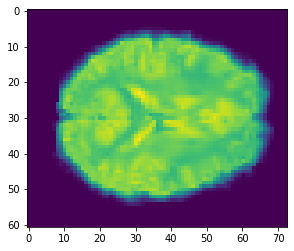

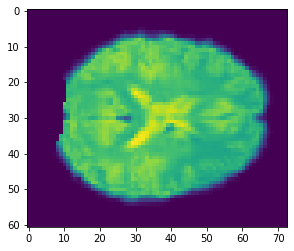

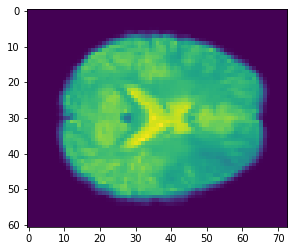

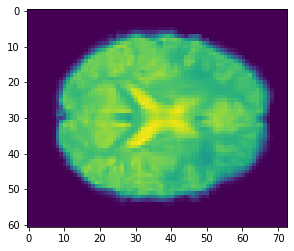

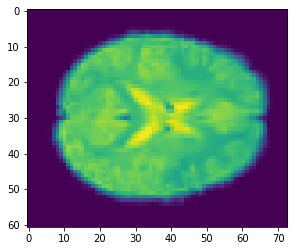

In [7]:
# Visualize 5 of the 391 images
for i in image_array[:5]: 
    plt.imshow(i[:,:,30])
    plt.show()

In [8]:
# #??? Ask Chelsea about this line of code. How is this phenotype data? 
# pheno = df[['FILE_ID', 'DX_GROUP']]
# pheno_array = np.array(pheno['DX_GROUP'])
# pheno_array = np.where(pheno_array == 2, 0, pheno_array) # This is a function to replace 2 with 0
# # distribution
# df['DX_GROUP'].value_counts()

# I think she means for this to be y label data right?
y = df[['FILE_ID', 'DSM_IV_TR', 'SEX_']] # 1 means Autism, 0 means Control
#y_array = np.array(y['DSM_IV_TR'])

#positive only 
#y_array = np.array(y.query("DSM_IV_TR == 1")["DSM_IV_TR"])

# female only (testing purposes)
y_array = np.array(y.query("DSM_IV_TR == 1 & SEX_ == 'Female'")["DSM_IV_TR"])

# male only (testing purposes)
y_array = np.array(y.query("DSM_IV_TR == 1 & SEX_ == 'Male'")["DSM_IV_TR"])

In [9]:
y_array

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [10]:
#x_train, x_test, y_train, y_test = train_test_split(image_array, pheno_array, test_size = 0.25, random_state = 44)
x_train, x_test, y_train, y_test = train_test_split(image_array, y_array, test_size = 0.25, random_state = 44)

In [11]:
x_train.shape

(93, 61, 73, 61)

In [12]:
# Checking imbalance of training set. Below is how you do value counts for np array. 
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[ 1, 93]])

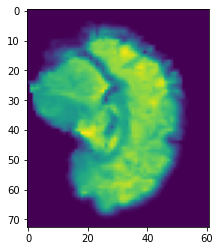

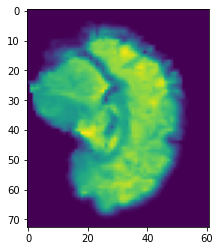

In [13]:
# first attempt at plotting 
#plt.imshow(x_train[:,:,30])
#TypeError: Invalid shape (293, 61, 61) for image data

#borrowing my other code for plotting
for i in x_train[:1]: 
    plt.imshow(i[30,:,:])
    plt.show()
    
# this code also works
plt.imshow(x_train[0][30])
plt.show()

In [14]:
# def train_preprocessing(volume, label):
#     """Process training data by rotating and adding a channel."""
#     # Rotate volume
#     volume = rotate(volume)
#     volume = tf.expand_dims(volume, axis=3) #??? Is the extra channel by how much the image was rotated? Ask Dylan.
#     return volume, label

# def validation_preprocessing(volume, label):
#     """Process validation data by only adding a channel."""
#     volume = tf.expand_dims(volume, axis=3)
#     return volume, label

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1 #return the integer of the division 
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image[30,:,:])
        #plt.imshow(image, cmap="binary")
        plt.axis("off")

In [15]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train)) # This is cool, double-check the documentation for this??? 
validation_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test)) #??? Should we have equal number of each class in our training data? 

batch_size = 16
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train)) # ??? shuffle dubplicates right? Or does it only shuffle? Double-check
#     .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE) # ??? I thought prefetch was for speed purposes. What is this tf.data.AUTOTUNE. Double-check. 
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_test))
#    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

2022-05-02 14:42:43.921405: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-02 14:42:43.921446: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (udc-aw29-23b): /proc/driver/nvidia/version does not exist
2022-05-02 14:42:43.924965: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# GAN

Cross section 30

In [16]:
#codings_size = 30 # What is this???
codings_size = 60 # What is this???
# Apparently, latent representations = coding 
# !!! Let's iterate through values of this to tst what effect it has 
generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(61 * 73 * 61, activation="sigmoid"),
    keras.layers.Reshape([61, 73, 61])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[61, 73, 61]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [17]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [18]:
batch_size = 32
#batch_size = 1 # Never finishes 
#batch_size = 150 # Errors out 
#x_train = tf.cast(x_train,tf.float32) # This was not in the texbook code. Test the effect of this 
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

#### Extracting the generated images

#### Option 1 

_Added a return generated_images statement_

In [19]:
#@tf.function
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs)) # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            #print(noise)
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            #print(X_fake_and_real)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            #print(y1)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1) #??? How does train_on_batch differ from fit? 
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8) # not shown 
        #plot_multiple_images(generated_images, 4) # not shown 
        plt.show() # not shown
    return generated_images # Not shown. Trying to figure out where to put this 

Epoch 1/50


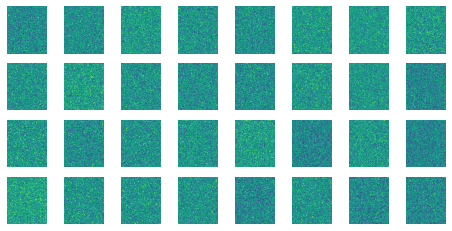

Epoch 2/50


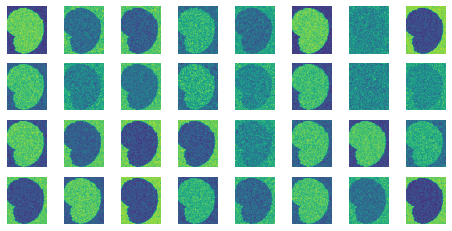

Epoch 3/50


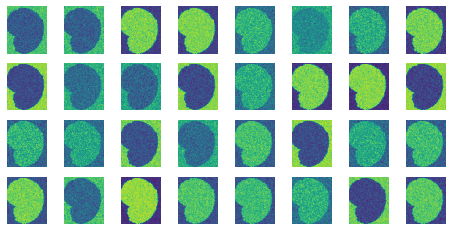

Epoch 4/50


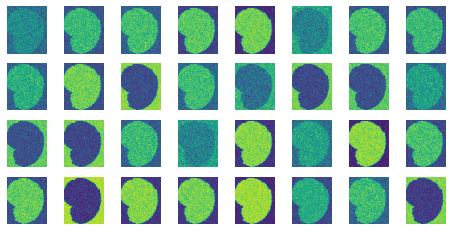

Epoch 5/50


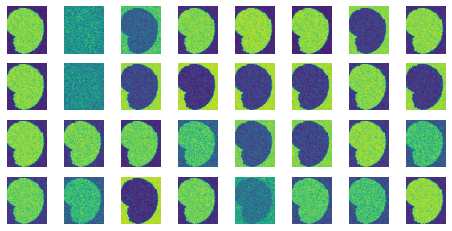

Epoch 6/50


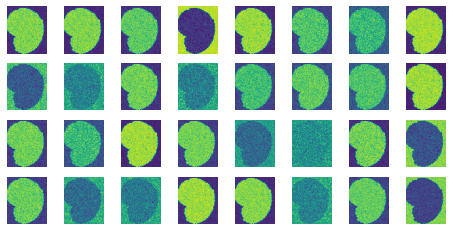

Epoch 7/50


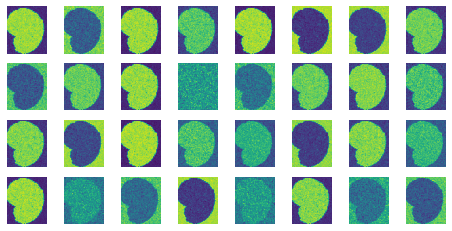

Epoch 8/50


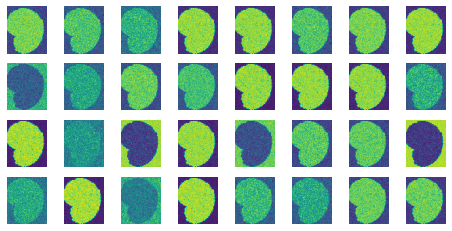

Epoch 9/50


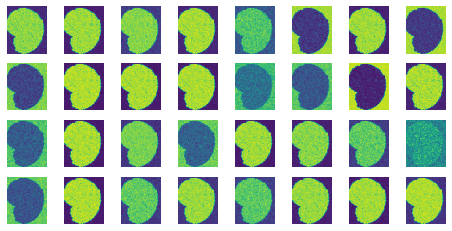

Epoch 10/50


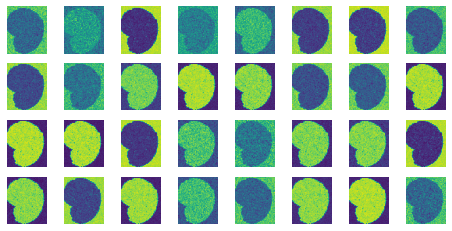

Epoch 11/50


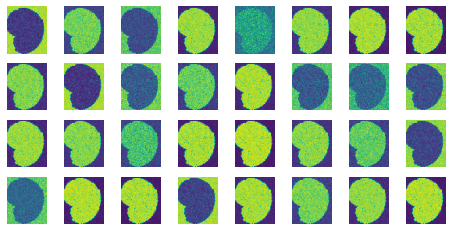

Epoch 12/50


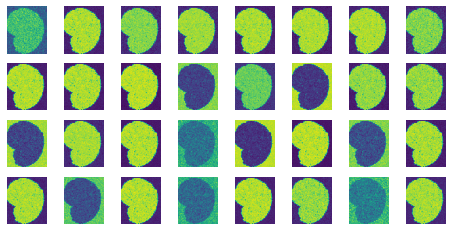

Epoch 13/50


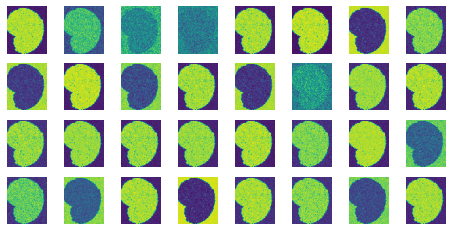

Epoch 14/50


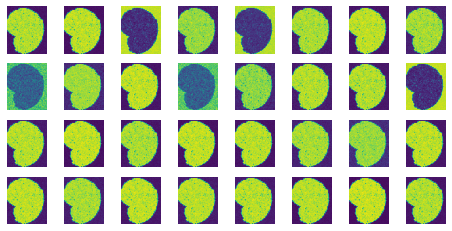

Epoch 15/50


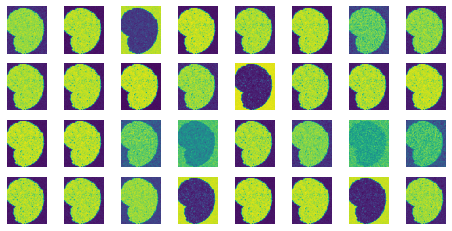

Epoch 16/50


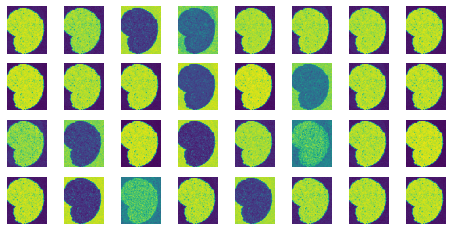

Epoch 17/50


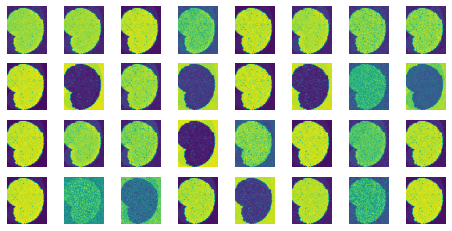

Epoch 18/50


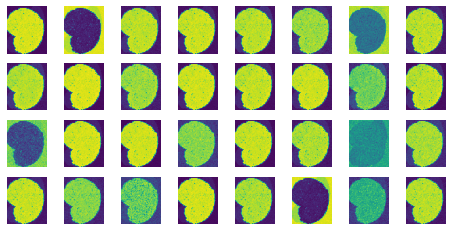

Epoch 19/50


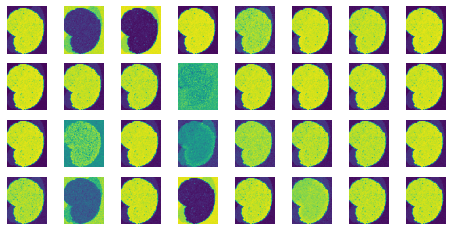

Epoch 20/50


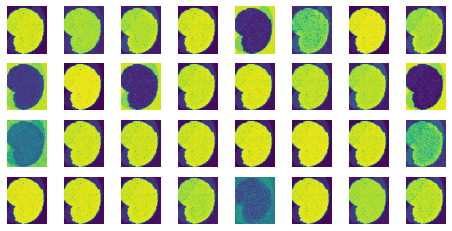

Epoch 21/50


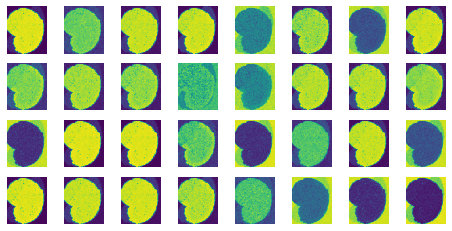

Epoch 22/50


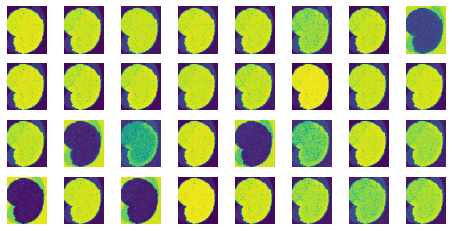

Epoch 23/50


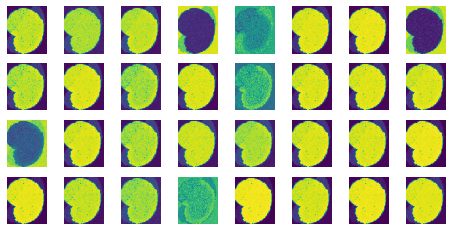

Epoch 24/50


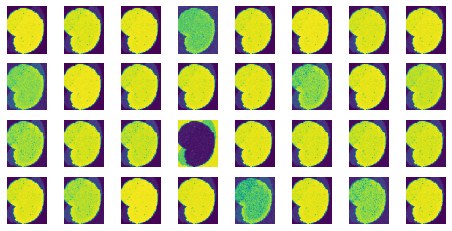

Epoch 25/50


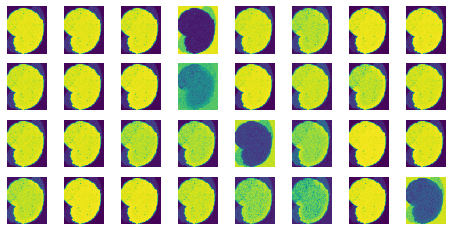

Epoch 26/50


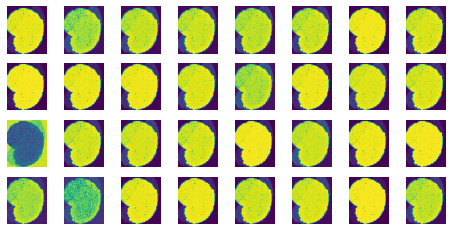

Epoch 27/50


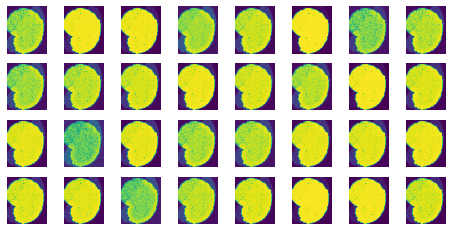

Epoch 28/50


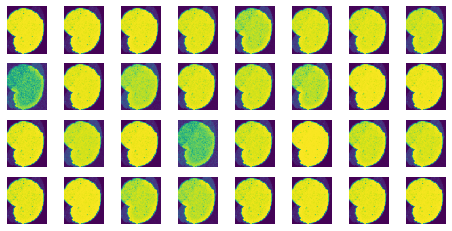

Epoch 29/50


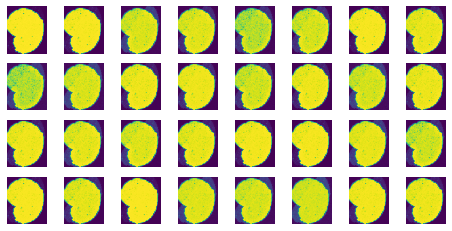

Epoch 30/50


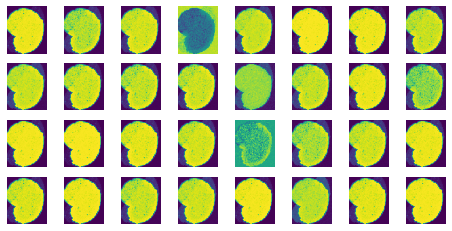

Epoch 31/50


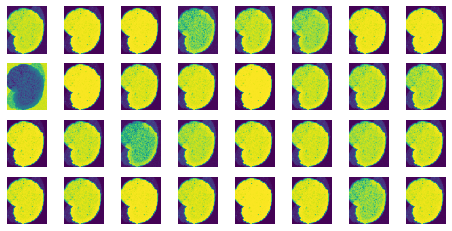

Epoch 32/50


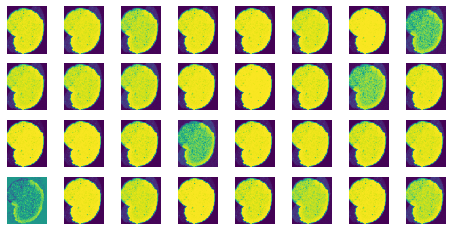

Epoch 33/50


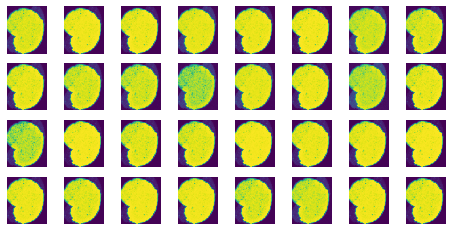

Epoch 34/50


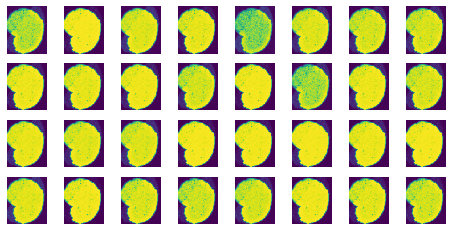

Epoch 35/50


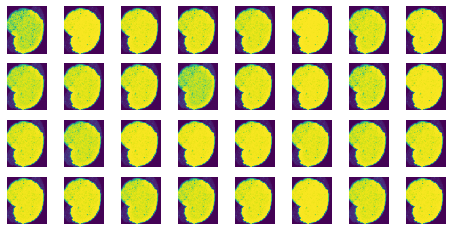

Epoch 36/50


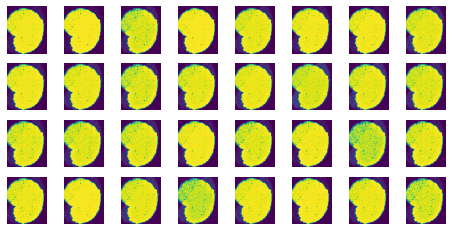

Epoch 37/50


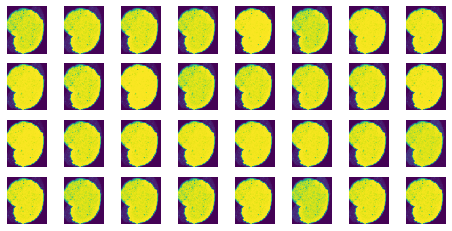

Epoch 38/50


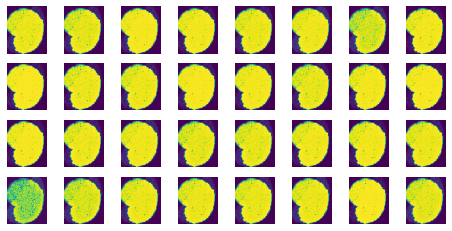

Epoch 39/50


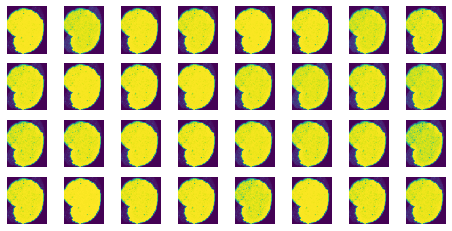

Epoch 40/50


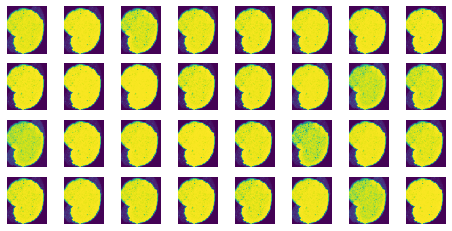

Epoch 41/50


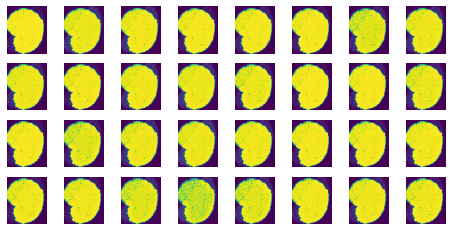

Epoch 42/50


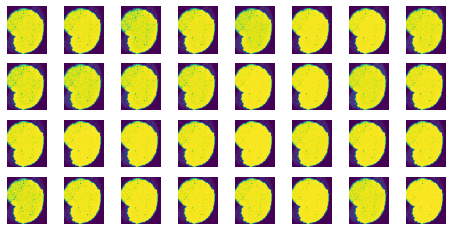

Epoch 43/50


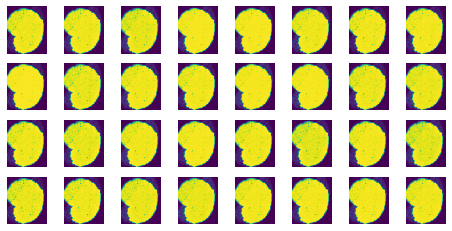

Epoch 44/50


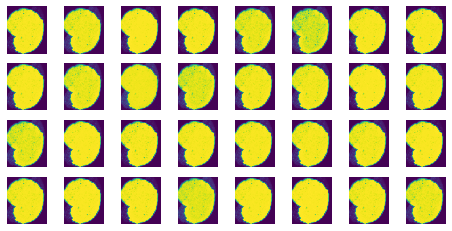

Epoch 45/50


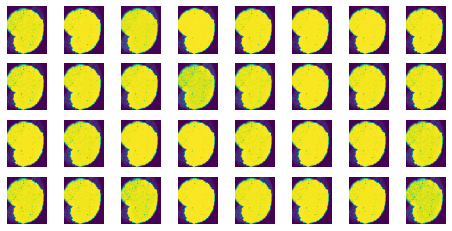

Epoch 46/50


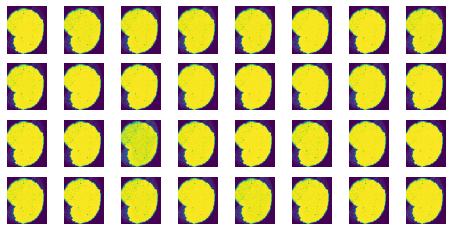

Epoch 47/50


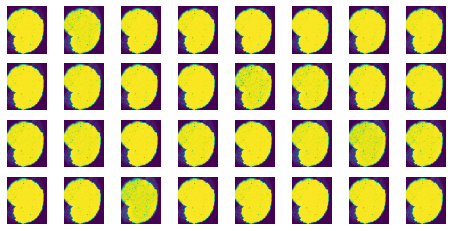

Epoch 48/50


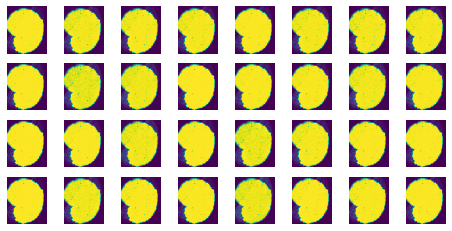

Epoch 49/50


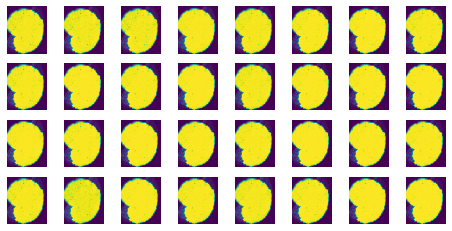

Epoch 50/50


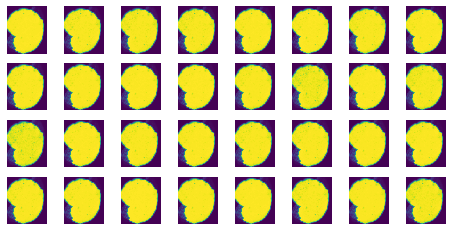

<tf.Tensor: shape=(32, 61, 73, 61), dtype=float32, numpy=
array([[[[0.00717357, 0.00643569, 0.00638142, ..., 0.00741714,
          0.00712213, 0.0077422 ],
         [0.00621548, 0.00641859, 0.00732413, ..., 0.00702327,
          0.00680479, 0.0063867 ],
         [0.00720516, 0.0070557 , 0.00641549, ..., 0.00744104,
          0.00719368, 0.00684509],
         ...,
         [0.00678346, 0.00717005, 0.00598159, ..., 0.0070211 ,
          0.00591728, 0.00677651],
         [0.00721011, 0.00682479, 0.00688186, ..., 0.00722939,
          0.00627777, 0.0068306 ],
         [0.00787184, 0.00744423, 0.00719774, ..., 0.0060418 ,
          0.00576437, 0.00759876]],

        [[0.00751311, 0.00688174, 0.00732771, ..., 0.00703251,
          0.00711039, 0.00682425],
         [0.00691566, 0.00647372, 0.00746444, ..., 0.00741428,
          0.00722146, 0.00689667],
         [0.00652009, 0.00642216, 0.00767085, ..., 0.00665137,
          0.00730738, 0.00725558],
         ...,
         [0.00679085, 0.006899

In [20]:
train_gan(gan, dataset, batch_size, codings_size)

#### Option 2

_Append generated_images from each epoch to a list (124 male cases / 32 batch_size = 4 batches * 50 epochs = 200 images in theory)_

In [21]:
generated = []
#@tf.function
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        #print("Epoch {}/{}".format(epoch + 1, n_epochs)) # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            #print(noise)
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            #print(X_fake_and_real)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            #print(y1)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1) #??? How does train_on_batch differ from fit? 
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        #plot_multiple_images(generated_images, 8) # not shown 
        #plot_multiple_images(generated_images, 4) # not shown 
        #plt.show() # not shown
            generated.append(generated_images) # Not shown. Trying to figure out where to put this 
    return generated

In [22]:
GAN = train_gan(gan, dataset, batch_size, codings_size)

In [23]:
GAN = tf.stack(GAN)
GAN.shape

#TensorShape([150, 32, 61, 73, 61]) for female + male (146) cases 
#TensorShape([0]) for female (22) cases 
#TensorShape([100, 32, 61, 73, 61]) for male (124) cases 

TensorShape([100, 32, 61, 73, 61])

In [24]:
GAN[0]

<tf.Tensor: shape=(32, 61, 73, 61), dtype=float32, numpy=
array([[[[0.01265219, 0.01134786, 0.01105562, ..., 0.01292571,
          0.01225165, 0.01258492],
         [0.01129743, 0.01094958, 0.01236799, ..., 0.01203901,
          0.01207268, 0.01130009],
         [0.01243794, 0.01233599, 0.01098633, ..., 0.01238722,
          0.01241258, 0.01188827],
         ...,
         [0.01194927, 0.01213303, 0.01016936, ..., 0.01252615,
          0.01049107, 0.01208079],
         [0.01157448, 0.01218161, 0.01197833, ..., 0.01249477,
          0.01124629, 0.01190171],
         [0.01278001, 0.01221439, 0.01236147, ..., 0.01077181,
          0.01103982, 0.01302537]],

        [[0.01274529, 0.01191726, 0.01260197, ..., 0.01256099,
          0.01240659, 0.01184002],
         [0.01185104, 0.01152039, 0.0123153 , ..., 0.0129489 ,
          0.01190701, 0.01132941],
         [0.01103827, 0.01117188, 0.01293781, ..., 0.0116477 ,
          0.01245722, 0.01222593],
         ...,
         [0.01182616, 0.011339

#### Option 3 

_Take the generated_images from Epoch 50 as our synthetic data_

In [25]:
#@tf.function
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs)) # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            #print(noise)
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            #print(X_fake_and_real)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            #print(y1)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1) #??? How does train_on_batch differ from fit? 
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        #plot_multiple_images(generated_images, 8) # not shown 
        #plot_multiple_images(generated_images, 4) # not shown 
        #plt.show() # not shown
    return generated_images # Not shown. Trying to figure out where to put this 

In [26]:
GAN = train_gan(gan, dataset, batch_size, codings_size)

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


In [27]:
GAN.shape

TensorShape([32, 61, 73, 61])

In [28]:
GAN.dtype

tf.float32

#### Option 4

_Assuming the weights got saved in the generator (class?), try applying the generator on the data_

In [35]:
noise = tf.random.normal(shape=[batch_size, codings_size])
#print(noise)
generated_images = generator(noise)

In [37]:
generated_images.shape

TensorShape([32, 61, 73, 61])

In [48]:
generated_images[0][0][0]

<tf.Tensor: shape=(61,), dtype=float32, numpy=
array([4.4163066e-06, 4.1047601e-06, 4.1854000e-06, 4.5454972e-06,
       4.5878287e-06, 4.3281416e-06, 4.5637926e-06, 4.6473124e-06,
       3.9907482e-06, 4.4274689e-06, 4.0979312e-06, 5.1515531e-06,
       4.2378551e-06, 3.9750530e-06, 4.6093837e-06, 4.3921891e-06,
       4.5758429e-06, 4.0185664e-06, 4.6467362e-06, 4.7088738e-06,
       4.4160370e-06, 4.9561095e-06, 4.4456792e-06, 4.2969341e-06,
       4.1878798e-06, 4.3915898e-06, 4.5414413e-06, 4.4929520e-06,
       4.9438781e-06, 3.9923125e-06, 4.2923716e-06, 4.6124528e-06,
       4.4560406e-06, 4.1558164e-06, 4.3606901e-06, 4.3009027e-06,
       4.2450106e-06, 4.3625496e-06, 4.4038070e-06, 4.4801413e-06,
       4.4892040e-06, 4.3165874e-06, 4.5385018e-06, 4.8563902e-06,
       4.3582331e-06, 4.3976670e-06, 4.6164882e-06, 4.1133853e-06,
       4.3463124e-06, 4.7761314e-06, 4.6112873e-06, 4.1035510e-06,
       4.3403393e-06, 4.7109761e-06, 4.1198041e-06, 4.3279806e-06,
       4.554683

In [47]:
#This is the same as Epoch 50 generated_images? No, fantastic! 
print((generated_images == GAN)[0][0][0])

tf.Tensor(
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False], shape=(61,), dtype=bool)


In [52]:
# To be doubly sure. Let's do that again! 
noise = tf.random.normal(shape=[batch_size, codings_size])
#print(noise)
generated_images_2 = generator(noise)

In [53]:
generated_images_2.shape

TensorShape([32, 61, 73, 61])

In [54]:
generated_images_2[0][0][0]

<tf.Tensor: shape=(61,), dtype=float32, numpy=
array([1.9830120e-06, 1.8142435e-06, 1.7945850e-06, 2.1582598e-06,
       1.9663701e-06, 1.9697316e-06, 2.0431303e-06, 2.0007026e-06,
       1.7892311e-06, 1.9780955e-06, 1.8406059e-06, 2.2496949e-06,
       1.9078498e-06, 1.8511046e-06, 2.0305044e-06, 1.9312670e-06,
       2.1387862e-06, 1.9106101e-06, 2.0396221e-06, 2.0210418e-06,
       2.0418195e-06, 2.2302982e-06, 2.0086500e-06, 1.9442898e-06,
       1.8362981e-06, 1.9988909e-06, 1.9315673e-06, 1.9817264e-06,
       2.1556411e-06, 1.8377066e-06, 1.9275226e-06, 1.9854851e-06,
       1.8877259e-06, 1.8582114e-06, 1.9157244e-06, 1.9195556e-06,
       1.7055614e-06, 1.8975757e-06, 1.9122708e-06, 2.0135312e-06,
       1.9902418e-06, 1.9156037e-06, 1.9905017e-06, 2.1533665e-06,
       1.9178631e-06, 2.0164771e-06, 2.0047173e-06, 1.8511505e-06,
       1.9292715e-06, 2.0521579e-06, 2.0042719e-06, 1.8335892e-06,
       2.0227233e-06, 2.0992713e-06, 1.9111405e-06, 1.9178722e-06,
       2.017525

In [55]:
#This is the same as Epoch 50 generated_images? No, fantastic! 
print((generated_images_2 == generated_images)[0][0][0])

tf.Tensor(
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False], shape=(61,), dtype=bool)


In [58]:
# trying a different batch_size 
batch_size = 16
noise = tf.random.normal(shape=[batch_size, codings_size])
#print(noise)
generated_images_3 = generator(noise)

In [59]:
generated_images_3.shape

TensorShape([16, 61, 73, 61])

In [63]:
# trying a different batch_size 
batch_size = 40
noise = tf.random.normal(shape=[batch_size, codings_size])
#print(noise)
generated_images_4 = generator(noise)

In [64]:
generated_images_4.shape

TensorShape([40, 61, 73, 61])

#### Saving the generated data

In [29]:
import numpy as np
import pickle
from pathlib import Path

path = Path('/project/ds6050-soa2wg/team_lambda_II/').expanduser()
path.mkdir(parents=True, exist_ok=True)

In [30]:
# using save (to npy), savez (to npz)
np.save(path/'gan', GAN)

## using loading npy, npz files
gan_loaded = np.load(path/'gan.npy')

In [31]:
gan_loaded.shape

(32, 61, 73, 61)

In [32]:
print(GAN == gan_loaded)

tf.Tensor(
[[[[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]

  [[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]

  [[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]]

  ...

  [[ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   [ True  True  True ...  True  True  True]
   ...
   

In [33]:
gan_loaded

array([[[[3.2597795e-06, 3.1276695e-06, 2.9474772e-06, ...,
          3.5027167e-06, 3.2076869e-06, 3.4625230e-06],
         [2.9688954e-06, 3.0740157e-06, 3.3858960e-06, ...,
          3.1421787e-06, 3.3017327e-06, 2.9583841e-06],
         [3.3951371e-06, 3.1417951e-06, 3.0367191e-06, ...,
          3.3012698e-06, 3.3009139e-06, 3.2455227e-06],
         ...,
         [3.1845948e-06, 3.1796906e-06, 2.6948574e-06, ...,
          3.4530390e-06, 2.7607932e-06, 3.1880134e-06],
         [3.2126188e-06, 3.1661225e-06, 3.1799514e-06, ...,
          3.3901028e-06, 3.0404631e-06, 3.1404350e-06],
         [3.3595502e-06, 3.2670216e-06, 3.2433261e-06, ...,
          2.8427123e-06, 2.8953898e-06, 3.4448917e-06]],

        [[3.4248019e-06, 3.1597758e-06, 3.2160613e-06, ...,
          3.3153856e-06, 3.3597810e-06, 3.1919317e-06],
         [3.2138753e-06, 3.0902761e-06, 3.4661407e-06, ...,
          3.3759266e-06, 3.2979153e-06, 3.2725941e-06],
         [3.0500323e-06, 2.9839964e-06, 3.5061489e-06, .